In [1]:
from plinder.core.scores import query_index
df = query_index(columns=['entry_pdb_id'], splits=["*"])

2025-03-04 13:42:13,959 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.64s
2025-03-04 13:42:15,669 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.62s


In [1]:
df = df.drop_duplicates('entry_pdb_id')
for pdb in df[ df['split'] == 'test' ][ 'entry_pdb_id' ]:
    print(pdb)

NameError: name 'df' is not defined

In [1]:
import pandas as pd

df = pd.read_csv('pdbbind_rosetta.csv', index_col=0)
df

,plindersplit,hacsplit,cleansplit,lppdbbindsplit,affinity_type,dG,vague_measures,covalent,fully_relaxed,nres,...,ligaway_total_fa_sol,ligaway_total_hbond_bb_sc,ligaway_total_hbond_lr_bb,ligaway_total_hbond_sc,ligaway_total_hbond_sr_bb,ligaway_total_omega,ligaway_total_p_aa_pp,ligaway_total_pro_close,ligaway_total_rama,ligaway_total_ref
10gs,train,train,test,train,Ki,8.727473,False,False,True,416.0,...,1293.723148,-44.637822,-44.383320,-78.719777,-305.027581,33.770246,-141.491896,2.293099,-63.311837,-106.46
11gs,train,train,train,train,Ki,7.944433,False,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13gs,train,val,train,train,Ki,6.301885,False,False,True,418.0,...,1304.641865,-38.406367,-44.726969,-76.516610,-305.293245,32.457901,-142.517987,1.234227,-71.201047,-107.08
16pk,removed,train,train,train,Ki,7.123159,False,False,True,415.0,...,1235.450496,-75.349186,-109.866629,-53.632265,-219.000525,33.956098,-147.758026,1.668328,-98.853136,-124.01
184l,train,train,train,train,Kd,6.440284,False,False,True,162.0,...,527.193675,-17.329138,-11.902224,-28.553003,-124.906950,17.040513,-45.723548,0.339356,-58.868174,-46.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966c,removed,train,NaN,val,Ki,10.419419,False,False,True,162.0,...,491.970002,-32.468009,-29.298600,-16.202111,-55.460115,16.192283,-56.402412,1.871896,9.933188,-21.50
9abp,train,train,NaN,train,Kd,10.912854,False,False,True,305.0,...,958.654476,-23.806635,-78.451502,-51.277298,-181.645635,95.698602,-81.593168,2.096123,-17.452140,-75.13
9hvp,NaN,train,train,train,Ki,11.385909,False,False,True,198.0,...,496.911813,-24.357985,-93.979846,-24.354186,-30.178365,30.290439,-78.683041,1.832259,-25.137098,-74.66
9icd,removed,train,train,train,Kd,5.324232,False,False,True,828.0,...,2519.132896,-115.354242,-208.133379,-143.796732,-433.739054,146.341119,-261.575721,5.276185,-80.114737,-233.04


In [2]:
for pdb in df[df['fully_relaxed']].index:
    with open( 'pdbbind_rosetta/' + pdb + '/' + pdb + '_relax.sdf' ) as file:
        for _ in range(4):
            line = file.readline()
        if 'V3000' in line:
            print(pdb, line)

1esz   0  0  0  0  0  0  0  0  0  0999 V3000

1k2v   0  0  0  0  0  0  0  0  0  0999 V3000



In [3]:
filters = [
    ('affinity_type', lambda x: x['affinity_type'] != 'IC50'),
    ('vague_measures', lambda x: ~x['vague_measures']),
    ('covalent', lambda x: ~x['covalent']),
    ('fully_relaxed', lambda x: x['fully_relaxed']),
    ('qed', lambda x: x['qed'] >= 0.2),
    ('has_rare_elem', lambda x: x['has_rare_element'] == False),
    ('rmsd_RelToCry', lambda x: x['rmsd_relax_to_crystal'] <= 4.0),
    ('relax_idelta', lambda x: x['relax_idelta_score'] >= -100000)
]
total = df.shape[0]
filter_impact = []
for f_name, f in filters:
    remaining = df[f(df)].shape[0]
    filter_impact.append((f_name,total-remaining))

filter_impact.sort(key=lambda x: x[1])
print("--- Filters sorted by removed IDs")
for fname, diff in filter_impact:
    print( fname, diff )

print()
print("--- Total size after iterative filter appliance")
df_f = df
for fname, diff in filter_impact:
    for f_name, f in filters:
        if fname == f_name:
            break
    prev = df_f.shape[0]
    df_f = df_f[f(df_f)]
    print(fname, df_f.shape[0], prev - df_f.shape[0])

names = []
removed_ids = []

for f_name, f in filters:
    names.append(f_name)
    removed_ids.append( list(df[~f(df)].index) )

padding = 15
print()
print("--- Overlap of removed IDs")
print(" ".rjust(padding), "".join([n.rjust( padding ) for n in names]), sep='')
for i in range(len(names)):
    print(names[i].rjust(padding), end='')
    for j in range(0, len(names)):
        print( str(len( [x for x in removed_ids[i] if x in removed_ids[j]] )).rjust(padding), end='' )
    print()

--- Filters sorted by removed IDs
vague_measures 504
has_rare_elem 834
covalent 893
relax_idelta 911
fully_relaxed 955
rmsd_RelToCry 1095
affinity_type 7190
qed 7648

--- Total size after iterative filter appliance
vague_measures 18939 504
has_rare_elem 18125 814
covalent 17290 835
relax_idelta 17177 113
fully_relaxed 17110 67
rmsd_RelToCry 16958 152
affinity_type 10748 6210
qed 6305 4443

--- Overlap of removed IDs
                 affinity_type vague_measures       covalent  fully_relaxed            qed  has_rare_elem  rmsd_RelToCry   relax_idelta
  affinity_type           7190            228            480            260           2297            244            310            262
 vague_measures            228            504             20             23            185             20             28             21
       covalent            480             20            893             52            260             39            102             54
  fully_relaxed            260      

In [4]:

splits = ['plindersplit', 
          'hacsplit', 
          'cleansplit', 
          'lppdbbindsplit']
padding = 15
clean_random_splitting = 0.9

print("--- Split sizes unfiltered")
print("Total IDs:", df.shape[0])
print(" ".rjust(padding), "".join([s.rjust( padding ) for s in splits]), sep='')
for t in ['train', 'val', 'test']:
    print(t.rjust(padding), end='')
    for s in splits:
        size = df[ df[s] == t ][s].shape[0]
        if s == 'cleansplit':
            if t == 'train':
                size = int(size * clean_random_splitting)
            elif t == 'val':
                size = int((1-clean_random_splitting) * df[ df[s] == 'train' ][s].shape[0])
        print(  str(size).rjust( padding ), end='' )
    print()

df_f = df
selected_filters = ['vague_measures', 'covalent', 'fully_relaxed', 'has_rare_elem', 'rmsd_RelToCry', 'relax_idelta']
for f_name, f in filters:
    if f_name not in selected_filters:
        continue
    df_f = df_f[f(df_f)]

print()
print("--- Split sizes filtered")
print("Total IDs after selected filters:", df_f.shape[0])
print(" ".rjust(padding), "".join([s.rjust( padding ) for s in splits]), sep='')
for t in ['train', 'val', 'test']:
    print(t.rjust(padding), end='')
    for s in splits:
        if t != 'test':
            size = df_f[ df_f[s] == t ][s].shape[0]
        else:
            size = df_f[ (df_f[s] == t) & (df_f['affinity_type'] != 'IC50') ][s].shape[0]
        if s == 'cleansplit':
            if t == 'train':
                size = int(size * clean_random_splitting)
            elif t == 'val':
                size = int((1-clean_random_splitting) * df_f[ df_f[s] == 'train' ][s].shape[0])
        print(  str(size).rjust( padding ), end='' )
    print()

--- Split sizes unfiltered
Total IDs: 19443
                  plindersplit       hacsplit     cleansplit lppdbbindsplit
          train          12025          18818          14420          11513
            val             40            300           1602           2422
           test             91            290            167           4860

--- Split sizes filtered
Total IDs after selected filters: 16958
                  plindersplit       hacsplit     cleansplit lppdbbindsplit
          train          10645          16394          12663           9705
            val             32            264           1406           2159
           test             38            283            157           2447


In [5]:
df['vague_measures'].value_counts()

vague_measures
False    18939
True       504
Name: count, dtype: int64

array([[<Axes: title={'center': 'rmsd_relax_to_crystal'}>]], dtype=object)

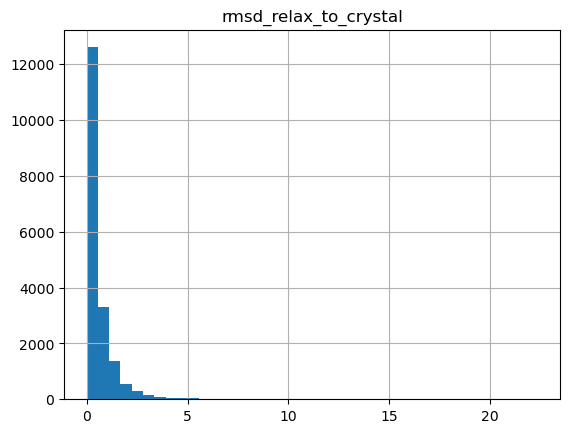

In [6]:
df.hist(column='rmsd_relax_to_crystal', bins=40)

[Text(1, 0, 'Crystal'), Text(2, 0, 'Relax')]

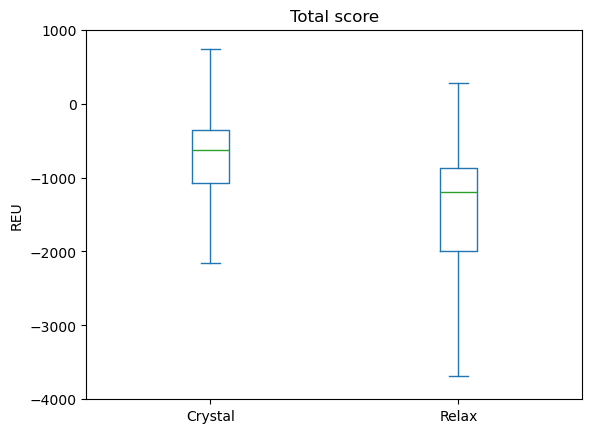

In [7]:
bp = df.plot.box(column=['crystal_total_score','relax_total_score'], ylabel='REU', title='Total score', showfliers=False, ylim=(-4000, 1000))
bp.set_xticklabels(['Crystal', 'Relax'])

[Text(1, 0, 'Crystal'), Text(2, 0, 'Relax')]

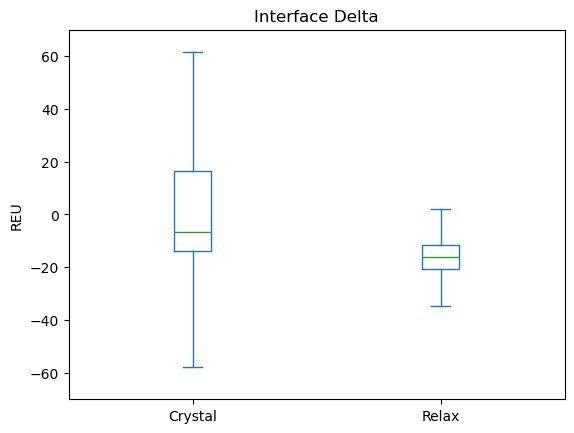

In [8]:
bp = df.plot.box(column=['crystal_idelta_score','relax_idelta_score'], ylabel='REU', title='Interface Delta', showfliers=False, ylim=(-70, 70))
bp.set_xticklabels(['Crystal', 'Relax'])

In [9]:
df['total_score_difference'] = (df['crystal_total_score'] - df['relax_total_score']).abs()
df['idelta_score_difference'] = (df['crystal_idelta_score'] - df['relax_idelta_score']).abs()

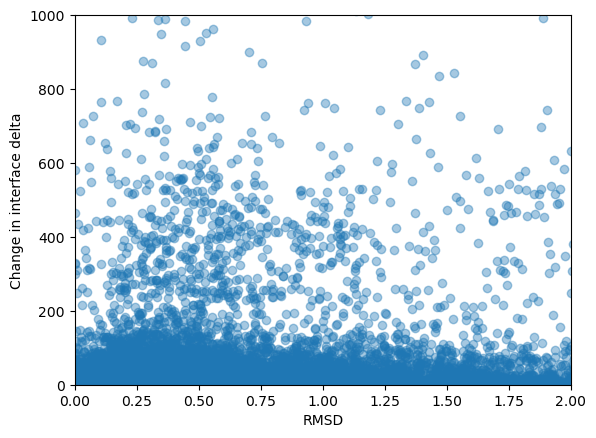

In [10]:
#df.plot.scatter('rmsd_relax_to_crystal', 'total_score_difference', ylim=(0,5000) )

from matplotlib import pyplot as plt

# crystal_idelta_score,relax_idelta_score
# relax_total_score-ligaway_total_score

plt.scatter(df.rmsd_relax_to_crystal, df.idelta_score_difference, alpha=0.4)
plt.xlim(0,2)
plt.ylim(0,1000)
plt.xlabel('RMSD')
plt.ylabel('Change in interface delta')
plt.show()

In [11]:
df[~df['rmsd_relax_to_crystal'].isna()]

,plindersplit,hacsplit,cleansplit,lppdbbindsplit,affinity_type,dG,vague_measures,covalent,fully_relaxed,nres,...,ligaway_total_hbond_lr_bb,ligaway_total_hbond_sc,ligaway_total_hbond_sr_bb,ligaway_total_omega,ligaway_total_p_aa_pp,ligaway_total_pro_close,ligaway_total_rama,ligaway_total_ref,total_score_difference,idelta_score_difference
10gs,train,train,test,train,Ki,8.727473,False,False,True,416.0,...,-44.383320,-78.719777,-305.027581,33.770246,-141.491896,2.293099,-63.311837,-106.46,496.186472,13.771504
13gs,train,val,train,train,Ki,6.301885,False,False,True,418.0,...,-44.726969,-76.516610,-305.293245,32.457901,-142.517987,1.234227,-71.201047,-107.08,530.979562,38.458711
16pk,removed,train,train,train,Ki,7.123159,False,False,True,415.0,...,-109.866629,-53.632265,-219.000525,33.956098,-147.758026,1.668328,-98.853136,-124.01,529.309862,58.570112
184l,train,train,train,train,Kd,6.440284,False,False,True,162.0,...,-11.902224,-28.553003,-124.906950,17.040513,-45.723548,0.339356,-58.868174,-46.02,312.451631,13.132691
185l,train,train,train,train,Kd,4.825667,False,False,True,162.0,...,-11.077210,-27.743668,-127.712030,16.300931,-44.540580,0.318245,-55.181607,-46.02,231.439983,2.358850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966c,removed,train,NaN,val,Ki,10.419419,False,False,True,162.0,...,-29.298600,-16.202111,-55.460115,16.192283,-56.402412,1.871896,9.933188,-21.50,510.453500,3.117461
9abp,train,train,NaN,train,Kd,10.912854,False,False,True,305.0,...,-78.451502,-51.277298,-181.645635,95.698602,-81.593168,2.096123,-17.452140,-75.13,1122.680686,6.121583
9hvp,NaN,train,train,train,Ki,11.385909,False,False,True,198.0,...,-93.979846,-24.354186,-30.178365,30.290439,-78.683041,1.832259,-25.137098,-74.66,910.224190,18.973606
9icd,removed,train,train,train,Kd,5.324232,False,False,True,828.0,...,-208.133379,-143.796732,-433.739054,146.341119,-261.575721,5.276185,-80.114737,-233.04,1584.298234,47.086374


In [12]:
df[df['rmsd_relax_to_crystal'] < 2]

,plindersplit,hacsplit,cleansplit,lppdbbindsplit,affinity_type,dG,vague_measures,covalent,fully_relaxed,nres,...,ligaway_total_hbond_lr_bb,ligaway_total_hbond_sc,ligaway_total_hbond_sr_bb,ligaway_total_omega,ligaway_total_p_aa_pp,ligaway_total_pro_close,ligaway_total_rama,ligaway_total_ref,total_score_difference,idelta_score_difference
10gs,train,train,test,train,Ki,8.727473,False,False,True,416.0,...,-44.383320,-78.719777,-305.027581,33.770246,-141.491896,2.293099,-63.311837,-106.46,496.186472,13.771504
13gs,train,val,train,train,Ki,6.301885,False,False,True,418.0,...,-44.726969,-76.516610,-305.293245,32.457901,-142.517987,1.234227,-71.201047,-107.08,530.979562,38.458711
16pk,removed,train,train,train,Ki,7.123159,False,False,True,415.0,...,-109.866629,-53.632265,-219.000525,33.956098,-147.758026,1.668328,-98.853136,-124.01,529.309862,58.570112
184l,train,train,train,train,Kd,6.440284,False,False,True,162.0,...,-11.902224,-28.553003,-124.906950,17.040513,-45.723548,0.339356,-58.868174,-46.02,312.451631,13.132691
185l,train,train,train,train,Kd,4.825667,False,False,True,162.0,...,-11.077210,-27.743668,-127.712030,16.300931,-44.540580,0.318245,-55.181607,-46.02,231.439983,2.358850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966c,removed,train,NaN,val,Ki,10.419419,False,False,True,162.0,...,-29.298600,-16.202111,-55.460115,16.192283,-56.402412,1.871896,9.933188,-21.50,510.453500,3.117461
9abp,train,train,NaN,train,Kd,10.912854,False,False,True,305.0,...,-78.451502,-51.277298,-181.645635,95.698602,-81.593168,2.096123,-17.452140,-75.13,1122.680686,6.121583
9hvp,NaN,train,train,train,Ki,11.385909,False,False,True,198.0,...,-93.979846,-24.354186,-30.178365,30.290439,-78.683041,1.832259,-25.137098,-74.66,910.224190,18.973606
9icd,removed,train,train,train,Kd,5.324232,False,False,True,828.0,...,-208.133379,-143.796732,-433.739054,146.341119,-261.575721,5.276185,-80.114737,-233.04,1584.298234,47.086374


In [13]:
df['plindersplit'].value_counts()

plindersplit
train         12025
removed        4156
unassigned     2370
test             91
val              40
Name: count, dtype: int64

In [14]:
df['hacsplit'].value_counts()

hacsplit
train    18818
val        300
test       290
Name: count, dtype: int64

In [15]:
df['cleansplit'].value_counts()

cleansplit
train    16023
test       167
Name: count, dtype: int64

In [16]:
df['lppdbbindsplit'].value_counts()

lppdbbindsplit
train    11513
test      4860
val       2422
Name: count, dtype: int64

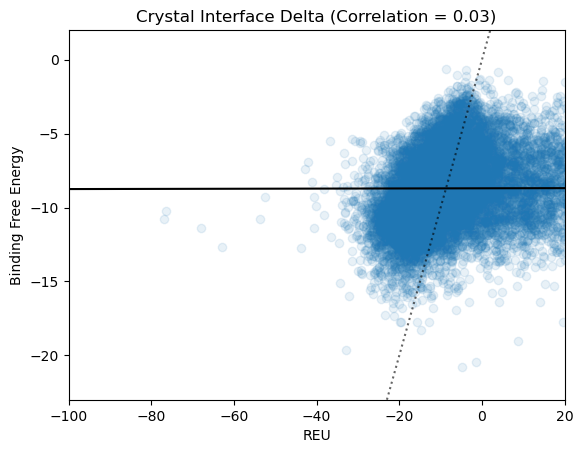

In [17]:
from matplotlib import pyplot as plt
import numpy as np

# crystal_idelta_score,relax_idelta_score
# relax_total_score-ligaway_total_score

#plt.scatter(-df_f.dG, df_f.relax_total_score - df_f.ligaway_total_score, alpha=0.1)
#plt.title('Bound-Unbound-Delta')
#plt.scatter(-df_f.dG, df_f.relax_total_score - df_f.ligaway_total_score, alpha=0.1)
#plt.title('Bound-Unbound-Delta')
 
title = 'Crystal Interface Delta'
x_data = df_f['crystal_idelta_score']
y_data = -df_f['dG']

correlation = x_data.corr(y_data)
slope, intercept = np.polyfit(x_data, y_data, 1)
fit_line = slope * np.arange(-150,50) + intercept
#perfect_line = 

plt.title(title + f' (Correlation = {correlation:.2f})')
plt.scatter(x_data, y_data, alpha=0.1, label='Data')
plt.plot(np.arange(-150,50), fit_line, color='black', label='Fit')
plt.xlim( -100, 20 )
plt.ylim(-23, 2)
plt.ylabel('Binding Free Energy')
plt.xlabel('REU')
plt.axline( [0,0], [1,1], color = 'black', alpha=0.6, linestyle=':' )
plt.show()

In [18]:
import numpy as np
import scipy
import scipy.stats


for split in splits:
    print("---", split)
    pred_names = [ 'crystal_idelta', '  relax_idelta', '    real_delta' ]

    dG = -np.array(df_f[df_f[split] == 'test'].dG)
    preds = [ np.array(df_f[df_f[split] == 'test'].relax_idelta_score),
            np.array(df_f[df_f[split] == 'test'].relax_idelta_score), 
            np.array(df_f[df_f[split] == 'test'].relax_total_score) - np.array(df_f[df_f[split] == 'test'].ligaway_total_score)
    ]

    for i in range(3):
        print( pred_names[i],
            f'rmse: {np.sqrt( np.mean( (preds[i]-dG)**2 ) ):.4f}',
            f'mae: {np.mean( np.abs(preds[i]-dG) ):.4f}',
            f'pcc: {scipy.stats.pearsonr(preds[i], dG)[0]:.4f}',)

--- plindersplit
crystal_idelta rmse: 9.9053 mae: 8.3071 pcc: 0.3373
  relax_idelta rmse: 9.9053 mae: 8.3071 pcc: 0.3373
    real_delta rmse: 11.6472 mae: 7.2317 pcc: 0.1596
--- hacsplit
crystal_idelta rmse: 9.2034 mae: 8.0314 pcc: 0.5656
  relax_idelta rmse: 9.2034 mae: 8.0314 pcc: 0.5656
    real_delta rmse: 8.2719 mae: 6.7970 pcc: 0.4671
--- cleansplit
crystal_idelta rmse: 9.0230 mae: 7.5259 pcc: 0.5933
  relax_idelta rmse: 9.0230 mae: 7.5259 pcc: 0.5933
    real_delta rmse: 7.7688 mae: 6.2433 pcc: 0.5485
--- lppdbbindsplit
crystal_idelta rmse: 9.7950 mae: 7.9595 pcc: 0.3285
  relax_idelta rmse: 9.7950 mae: 7.9595 pcc: 0.3285
    real_delta rmse: 11.2771 mae: 7.1897 pcc: 0.2138


(16958, 20)


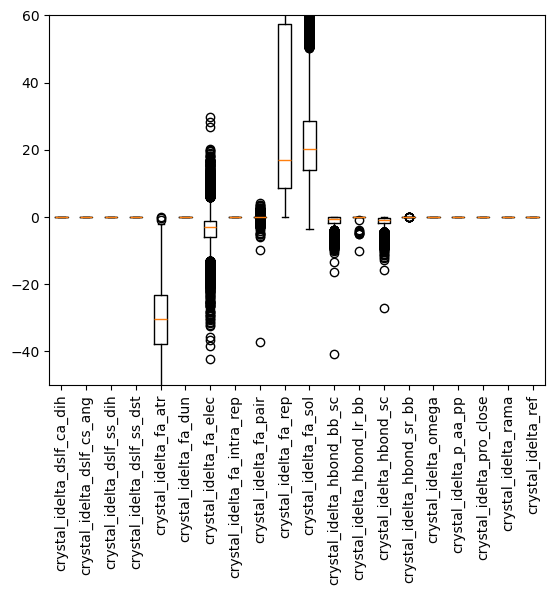

In [19]:
mask = (df_f.columns.str.contains('crystal_idelta_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'crystal_idelta_score')
names = df_f.columns[mask]
raw_crystal_idelta = np.array( df_f.loc[:, mask ] )
print(raw_crystal_idelta.shape)
plt.boxplot([ raw_crystal_idelta[:,i] for i in range(len(names))],labels=names)
plt.xticks(rotation=90)
plt.ylim( -50,60 )
plt.show()

(16958, 20)


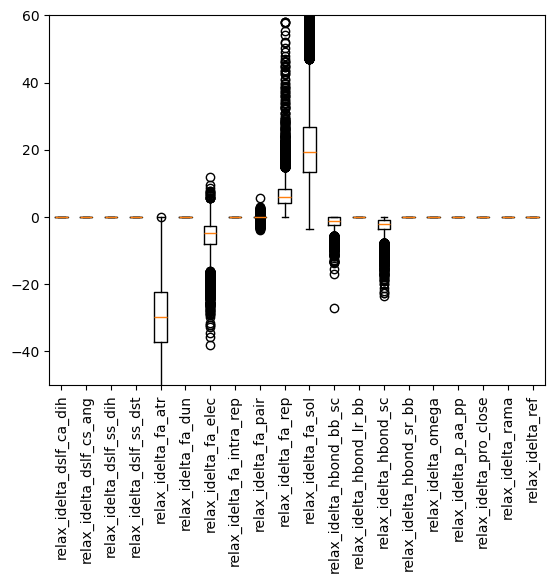

In [20]:
mask = (df_f.columns.str.contains('relax_idelta_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'relax_idelta_score')
names = df_f.columns[mask]
raw_relax_idelta = np.array( df_f.loc[:, mask ] )
print(raw_relax_idelta.shape)
plt.boxplot([ raw_relax_idelta[:,i] for i in range(len(names))],labels=names)
plt.xticks(rotation=90)
plt.ylim( -50,60 )
plt.show()

(16958, 20)


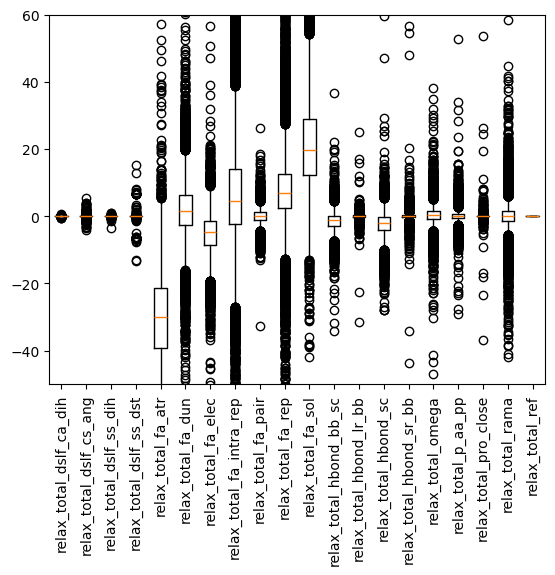

In [21]:
mask_relax = (df_f.columns.str.contains('relax_total_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'relax_total_score')
names = df_f.columns[mask_relax]
raw_relax_total = np.array( df_f.loc[:, mask_relax ] )

mask_ligaway = (df_f.columns.str.contains('ligaway_total_*')) & ~(df_f.columns.str.contains('chainbreak')) & ~(df_f.columns.str.contains('constraint')) & (df_f.columns != 'ligaway_total_score')
raw_ligaway_total = np.array( df_f.loc[:, mask_ligaway ] )

raw_real_delta = raw_relax_total - raw_ligaway_total

print(raw_real_delta.shape)
plt.boxplot([ raw_real_delta[:,i] for i in range(len(names))],labels=names)
plt.xticks(rotation=90)
plt.ylim( -50,60 )
plt.show()

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader

class RosettaEnergies( Dataset ):

    def __init__( self, energies, dGs ):
        self.energies = torch.tensor( energies, dtype=torch.float32 )
        self.dGs = torch.tensor( dGs, dtype=torch.float32 )
        assert len( self.dGs ) == len( self.energies ), "Energies and dGs differ in length"

    def __len__(self):
        return len(self.dGs)
    
    def __getitem__(self, idx):
        return self.energies[idx], self.dGs[idx]
    
dG = -np.array(df_f.dG)



In [38]:
t = torch.zeros(20)
mask = raw_relax_idelta[0].nonzero()[0]
t[mask] = 1
t

tensor([0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0.])

In [47]:
from torch import nn
import copy
import torch.nn.utils.parametrize as parametrize

class SoftplusParameterization(nn.Module):
    def forward(self, X):
        return nn.functional.softplus(X)

model = nn.Linear(20,1,bias=False)
parametrize.register_parametrization(model, "weight", SoftplusParameterization())
assert torch.all(model.weight>0)

learning_rate = 0.001
epochs = 2000
batch_size = 512

split = 'lppdbbindsplit'
energies = raw_relax_idelta

train_mask = np.array(df_f[split] == 'train')
train_set = RosettaEnergies( energies[train_mask], dG[train_mask] )
train_loader = DataLoader( train_set, batch_size=batch_size, shuffle=True )

val_mask = np.array(df_f[split] == 'val')
val_set = RosettaEnergies( energies[val_mask], dG[val_mask] )
val_loader = DataLoader( val_set, batch_size=batch_size, shuffle=True )

test_mask = np.array(df_f[split] == 'test')
test_set = RosettaEnergies( energies[test_mask], dG[test_mask] )
test_loader = DataLoader( test_set, batch_size=10000, shuffle=True )

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

device = 'cuda'
model = model.to(device)
print("Learnable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

best_val_loss = 9999999.99
best_val_model = copy.deepcopy(model)
best_epoch = -1

for e in range(1, epochs+1):

    inform = e % 10 == 0

    model.train()
    mse = 0
    mae = 0
    total_loss = 0
    steps = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x).squeeze()
        loss = loss_fn( pred, y )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        mse += torch.mean( (pred-y)**2 )
        mae += torch.mean( torch.abs( pred - y ) )
        total_loss += loss.item()
        steps += 1
        

    mae = mae / steps
    rmse = torch.sqrt( mse / steps )
    total_loss = total_loss / steps
    if inform: print( f"train loss: {total_loss:>7.10f} rmse: {rmse:>5.4f} mae: {mae:>5.4f} [{e:>5d}/{epochs:>5d}]" )

    model.eval()
    with torch.no_grad():
        mse = 0
        mae = 0
        total_loss = 0
        steps = 0
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x).squeeze()
            loss = loss_fn( pred, y )

            mse += torch.mean( (pred-y)**2 )
            mae += torch.mean( torch.abs( pred - y ) )
            total_loss += loss.item()
            steps += 1

        mae = mae / steps
        rmse = torch.sqrt( mse / steps )
        total_loss = total_loss / steps
        if total_loss < best_val_loss:
            best_val_loss = total_loss
            best_val_model = copy.deepcopy(model)
            best_epoch = e
        if inform: print( f"valid loss: {total_loss:>7.10f} rmse: {rmse:>5.4f} mae: {mae:>5.4f} [{e:>5d}/{epochs:>5d}]" )

print('Selected model with best validation loss from epoch', best_epoch)
print(best_val_loss)
mask = raw_relax_idelta[0].nonzero()[0]
print(best_val_model.weight[0][mask])
best_val_model.eval()

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        pred = best_val_model(x).squeeze()
        loss = loss_fn( pred, y )

        rmse = torch.sqrt(torch.mean( (pred-y)**2 ))
        mae = torch.mean( torch.abs( pred - y ) )
        total_loss = loss.item()
        pearson = scipy.stats.pearsonr(pred.cpu().numpy(), y.cpu())[0]

    print( f"Test loss: {total_loss:>7.10f} rmse: {rmse:>5.4f} mae: {mae:>5.4f} pcc: {pearson:>5.4f}" )

#print(model.weight)
#print(model.bias)

Learnable params: 20
train loss: 4.1982556017 rmse: 14.0000 mae: 4.1983 [   10/ 2000]
valid loss: 3.3671058178 rmse: 4.7352 mae: 3.3671 [   10/ 2000]
train loss: 3.9514467465 rmse: 12.6685 mae: 3.9514 [   20/ 2000]
valid loss: 3.2658599854 rmse: 4.5981 mae: 3.2659 [   20/ 2000]
train loss: 3.7357034056 rmse: 11.4441 mae: 3.7357 [   30/ 2000]
valid loss: 3.1636122227 rmse: 4.3422 mae: 3.1636 [   30/ 2000]
train loss: 3.5493370106 rmse: 10.3666 mae: 3.5493 [   40/ 2000]
valid loss: 2.9592045784 rmse: 4.0227 mae: 2.9592 [   40/ 2000]
train loss: 3.3923512885 rmse: 9.4164 mae: 3.3924 [   50/ 2000]
valid loss: 2.8501343727 rmse: 3.8474 mae: 2.8501 [   50/ 2000]
train loss: 3.2614593757 rmse: 8.6099 mae: 3.2615 [   60/ 2000]
valid loss: 2.7174603939 rmse: 3.6433 mae: 2.7175 [   60/ 2000]
train loss: 3.1499851628 rmse: 7.8946 mae: 3.1500 [   70/ 2000]
valid loss: 2.7415550709 rmse: 3.6625 mae: 2.7416 [   70/ 2000]
train loss: 3.0588592730 rmse: 7.3325 mae: 3.0589 [   80/ 2000]
valid loss: 2.6

In [48]:
print(best_val_model.weight[0][mask])

tensor([0.3199, 0.0926, 0.0464, 0.0221, 0.1497, 0.0463, 0.3201],
       device='cuda:0', grad_fn=<IndexBackward0>)


In [49]:
df_f['pred_dG'] = df['relax_idelta_fa_atr'] * best_val_model.weight[0][mask][0].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_elec'] * best_val_model.weight[0][mask][1].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_pair'] * best_val_model.weight[0][mask][2].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_rep'] * best_val_model.weight[0][mask][3].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_fa_sol'] * best_val_model.weight[0][mask][4].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_hbond_bb_sc'] * best_val_model.weight[0][mask][5].cpu().detach().numpy()
df_f['pred_dG'] += df['relax_idelta_hbond_sc'] * best_val_model.weight[0][mask][6].cpu().detach().numpy()

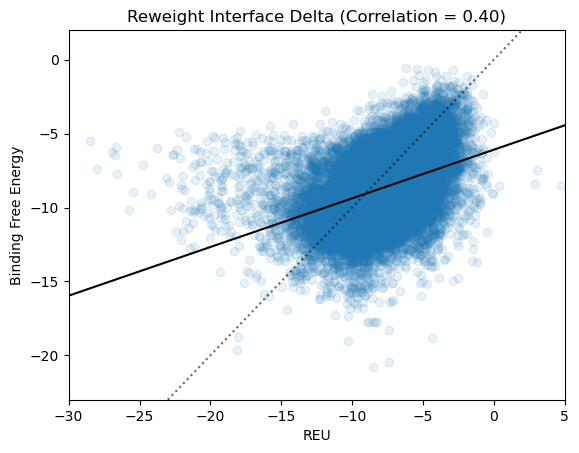

In [52]:


title = 'Reweight Interface Delta'
x_data = df_f['pred_dG']
y_data = -df_f['dG']

correlation = x_data.corr(y_data)
slope, intercept = np.polyfit(x_data, y_data, 1)
fit_line = slope * np.arange(-150,50) + intercept
#perfect_line = 

plt.title(title + f' (Correlation = {correlation:.2f})')
plt.scatter(x_data, y_data, alpha=0.1, label='Data')
plt.plot(np.arange(-150,50), fit_line, color='black', label='Fit')
plt.xlim( -30, 5 )
plt.ylim(-23, 2)
plt.ylabel('Binding Free Energy')
plt.xlabel('REU')
plt.axline( [0,0], [1,1], color = 'black', alpha=0.6, linestyle=':' )
plt.show()

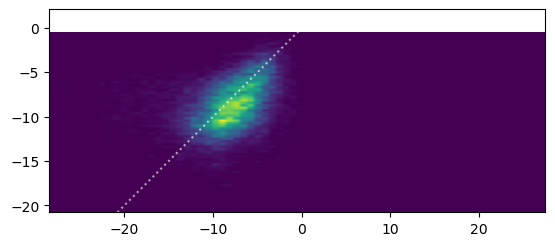

In [65]:
heatmap, xedges, yedges = np.histogram2d(x_data, y_data, bins=70)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.axline( [0,0], [1,1], color = 'white', alpha=0.6, linestyle=':' )
plt.show()